# Bayesian Linear Regression

Edward can excecute 

An comparison of these algorighms
various types of MCMC algorighms
- Metropolis-Hastings
- Gibbs sampling
- Hamilton Monte-Carlo (HMC)
- Stchastic Gradient MCMC(SGMCMC)

The model is same as the one of supervised-regression 
http://edwardlib.org/tutorials/supervised-regression.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import pandas as pd

from edward.models import Normal, Empirical

plt.style.use('ggplot')

Couldn't import dot_parser, loading of dot files will not be possible.


## Data

Simulate training and test sets of $40$ data points. They comprise of
pairs of inputs $\mathbf{x}_n\in\mathbb{R}^{10}$ and outputs
$y_n\in\mathbb{R}$. They have a linear dependence with normally
distributed noise.

In [2]:
def build_toy_dataset(N, w):
  D = len(w)
  x = np.random.normal(0.0, 2.0, size=(N, D))
  y = np.dot(x, w) + np.random.normal(0.0, 0.01, size=N)
  return x, y


ed.set_seed(42)

N = 40  # number of data points
D = 10  # number of features

w_true = np.random.randn(D) * 0.5
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

## Model

Posit the model as Bayesian linear regression (Murphy, 2012).
It assumes a linear relationship between the inputs
$\mathbf{x}\in\mathbb{R}^D$ and the outputs $y\in\mathbb{R}$.

For a set of $N$ data points $(\mathbf{X},\mathbf{y})=\{(\mathbf{x}_n, y_n)\}$,
the model posits the following distributions:

\begin{align*}
  p(\mathbf{w})
  &=
  \text{Normal}(\mathbf{w} \mid \mathbf{0}, \sigma_w^2\mathbf{I}),
  \\[1.5ex]
  p(b)
  &=
  \text{Normal}(b \mid 0, \sigma_b^2),
  \\
  p(\mathbf{y} \mid \mathbf{w}, b, \mathbf{X})
  &=
  \prod_{n=1}^N
  \text{Normal}(y_n \mid \mathbf{x}_n^\top\mathbf{w} + b, \sigma_y^2).
\end{align*}

The latent variables are the linear model's weights $\mathbf{w}$ and
intercept $b$, also known as the bias.
Assume $\sigma_w^2,\sigma_b^2$ are known prior variances and $\sigma_y^2$ is a
known likelihood variance. The mean of the likelihood is given by a
linear transformation of the inputs $\mathbf{x}_n$.

Let's build the model in Edward, fixing $\sigma_w,\sigma_b,\sigma_y=1$.

In [3]:
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

tf.placeholder is used for container of obserbed variable X. target variable y is  This is model (dot(X,w)+b).

## Inference


In [4]:
T = 5000                        # Number of samples.
nburn = 100                     # Number of burn-in samples.
stride = 10                    # Frequency with which to plot samples.

In [5]:
qw = Empirical(params=tf.Variable(tf.random_normal([T, D])))
qb = Empirical(params=tf.Variable(tf.random_normal([T, 1])))

hidden variable should be Empirical in MCMC.

by MCMC

#### HMC

In [6]:
inference_HMC = ed.HMC({w: qw, b: qb}, data={X: X_train, y: y_train})
inference_HMC.run(step_size=1e-3)
y_post_HMC = ed.copy(y, {w: qw, b: qb})
qw_HMC,qb_HMC=qw,qb

5000/5000 [100%] ██████████████████████████████ Elapsed: 4s | Acceptance Rate: 1.000


In [7]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post_HMC: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post_HMC: y_test}))

Mean squared error on test data:
4.25284
Mean absolute error on test data:
1.62384


#### SGMCMC

In [8]:
inference_SGHMC=ed.SGHMC({w: qw, b: qb}, data={X: X_train, y: y_train})
inference_SGHMC.run(step_size=1e-3)
y_post_SGHMC = ed.copy(y, {w: qw, b: qb})
qw_SGHMC,qb_SGHMC=qw,qb

5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Acceptance Rate: 1.000


In [9]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post_SGHMC: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post_SGHMC: y_test}))

Mean squared error on test data:
0.0176847
Mean absolute error on test data:
0.0932609


#### Gibbs

In [17]:
inference_Gibbs=ed.Gibbs({w: qw, b: qb},{w:w,b:b}, data={X: X_train, y: y_train})
inference_Gibbs.run()
y_post_Gibbs = ed.copy(y, {w: qw, b: qb})
qw_Gibbs,qb_Gibbs=qw,qb

5000/5000 [100%] ██████████████████████████████ Elapsed: 8s | Acceptance Rate: 1.000


In [18]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post_Gibbs: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post_Gibbs: y_test}))

Mean squared error on test data:
35.6354
Mean absolute error on test data:
4.79237


## Criticism


In [11]:
def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  plt.scatter(X_data[:, 0], y_data)
  plt.ylim([-10, 10])
  inputs = np.linspace(-8, 8, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

### Prot prior samples

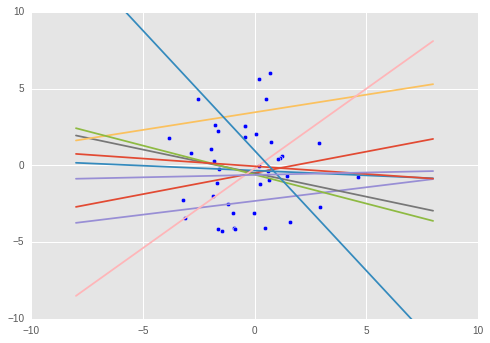

In [12]:
visualise(X_train, y_train, w, b, n_samples=10)

### Plot posterior samples

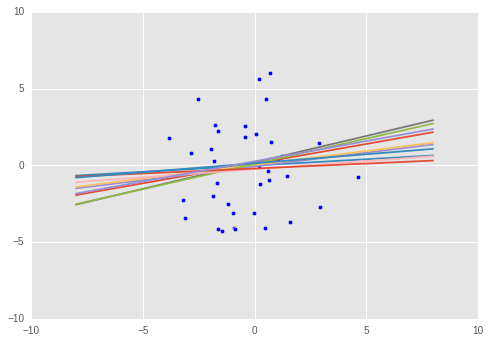

In [13]:
visualise(X_train, y_train, qw_HMC, qb_HMC, n_samples=10)

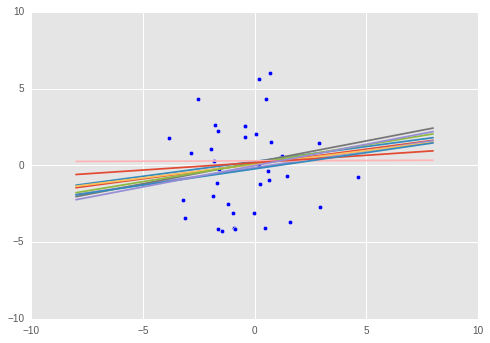

In [14]:
visualise(X_train, y_train, qw_SGHMC, qb_SGHMC, n_samples=10)

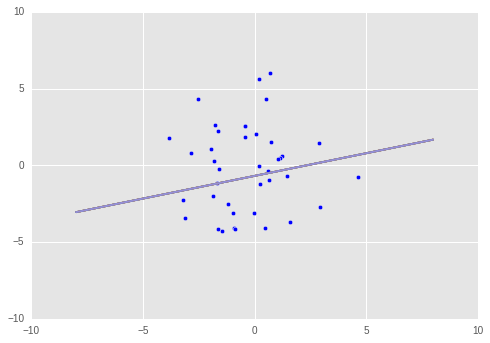

In [19]:
visualise(X_train, y_train, qw_Gibbs, qb_Gibbs, n_samples=10)

The model has captured the relationship between $x$ and $y$ in the observed domain.

To learn more about Edward, [delve in](http://edwardlib.org/api)!

If you prefer to learn via examples, then check out some
[tutorials](http://edwardlib.org/tutorials/).